In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import yaml
from glob import glob
import os
import pandas as pd
import json
import pickle
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import torch.nn as nn



In [3]:
# Occlusion Mask Functions

# Calculate the occlusion maps for a given model and a single sample
def pseudo_occlusion_sensitivity(model, X, reference, occlusion_size=1, stride=1, occlusion_value=0, model_type='reid',batch_size=1, verbose=False, plot_occluded_imgs=False):
 
    if occlusion_size < 1:
        print(f'ERROR - invalid occlusion size {occlusion_size}')
        print(f'Using a value of 1 instead')
        occlusion_size = 1

    output = np.zeros((X.shape[1], X.shape[2]))
    averaging_mask = np.zeros((X.shape[1], X.shape[2]))

    # Get the total number of occlusion windows
    n_windows = ((X.shape[1] - occlusion_size) // stride + 1) * ((X.shape[2] - occlusion_size) // stride + 1)
  
    # Create an array to store all occluded images
    occluded_images = np.empty((n_windows, *X.shape))

    if verbose:
        print(f'X shape: {X.shape}')
        print(f'output shape: {output.shape}')
        print(f'occluded_images shape: {occluded_images.shape}')
    
    # Create an array to store the indices of the occluded windows
    indices = np.empty((n_windows, 4), dtype=int)

    count = 0
    # for j in range(0, X.shape[1]+1, stride):
    #     for k in range(0, X.shape[2]+1, stride):
    for j in range(0, X.shape[1] - occlusion_size + 1, stride):
        for k in range(0, X.shape[2] - occlusion_size + 1, stride):
             # Create a copy of the image
            x_occluded = X.clone().cpu() 

            # Apply the occlusion
            x1, x2 = j, j + occlusion_size
            y1, y2 = k, k + occlusion_size
            x_occluded[:, x1:x2, y1:y2] = occlusion_value
            
            occluded_images[count] = x_occluded
            indices[count] = np.array([x1, x2, y1, y2])
            count += 1

    if plot_occluded_imgs:
        # Display the occluded images to examine them
        # Calculate the number of rows needed
        n_rows = n_windows // 10
        if n_windows % 10 > 0:
            n_rows += 1

        fig, ax = plt.subplots(n_rows, 10, figsize=(20, 2 * n_rows))

        for i in range(n_windows):
            row = i // 10
            col = i % 10
            # Transpose the image from (channels, height, width) to (height, width, channels)
            image = np.transpose(occluded_images[i], (1, 2, 0))
            ax[row, col].imshow(image)
            ax[row, col].axis('off')  # Hide axis

        # If the number of images is not a multiple of 10, hide the remaining subplots
        for i in range(n_windows, n_rows * 10):
            row = i // 10
            col = i % 10
            ax[row, col].axis('off')

        plt.show()

    occluded_images = torch.from_numpy(occluded_images).float().cuda()

    print(f'Length of occluded_images: {len(occluded_images)}')

    # Process the occluded images in batches
    for i in range(0, n_windows, batch_size):
        # Get the current batch of occluded images
        batch = occluded_images[i:i+batch_size]
        # Make predictions for the batch
        predictions = model(batch)

        # Apply sigmoid if model_type is 'color_detect'
        if model_type == 'color_detect':
            #print('Applying sigmoid')
            predictions = torch.sigmoid(predictions)

        # Move predictions to CPU
        predictions = predictions.cpu().detach().numpy()
        # Compute the sensitivity for each image in the batch
        for j in range(len(batch)):
            x1, x2, y1, y2 = indices[i+j]
            # Compute the difference
            diff = 1.0 - np.dot(predictions[j], reference)
            output[x1:x2, y1:y2] += diff
            averaging_mask[x1:x2, y1:y2] += 1
            torch.cuda.empty_cache() # Free up GPU memory

    #print(output.shape)
    output = np.where(averaging_mask != 0, output / averaging_mask, 0)
    #output = np.divide(output, averaging_mask)
    # plt.imshow(averaging_mask, cmap='gray')
    # plt.colorbar()
    # plt.show()
    return output

    
def get_occlusion_maps(model, samples, occlusion_size, stride, occlusion_value=0, model_type='reid', batch_size=64, verbose=False, plot_occluded_imgs=False):
    ref_value = model(samples)
    if model_type == 'color_detect':
        ref_value = torch.sigmoid(ref_value)
    ref_value = ref_value.cpu().detach().numpy()
    
    results = []
    start = time.time()
    for k in range(samples.shape[0]):
        temp = pseudo_occlusion_sensitivity(model, samples[k], ref_value[k], occlusion_size, stride, occlusion_value, model_type=model_type, batch_size=batch_size, verbose=verbose, plot_occluded_imgs=plot_occluded_imgs)
        results.append(temp)
    stop = time.time()
    print('Total time:',(stop-start)/60)
    return results



In [24]:
# Plotting Functions

def plot_occlusion_maps(samples, results, savefig=False, figname=None, quantile1=0.99, quantile2=0.9):
    N = len(samples)
    fig = plt.figure(figsize=(3*N, 2*N))  # Adjust the figure size to accommodate 3 rows
    for k in range(N):
        # Plot the original image
        ax = plt.subplot(3, N, k+1)
        ax.axis('off')
        # Transpose the image data to the correct shape
        image = samples[k].permute(1, 2, 0).cpu()
        plt.imshow(image)  

        # Plot the occlusion map
        ax2 = plt.subplot(3, N, N+k+1)
        ax2.axis('off')
        result = results[k]
        plt.imshow(result, cmap='inferno')

        # Plot the occlusion map with thresholding overlayed in the original image
        thresholded_results = (results[k] > np.quantile(results[k], quantile1)).astype(int)
        ax3 = plt.subplot(3, N, 2*N+k+1)
        ax3.axis('off')
        plt.imshow(samples[k].permute(1, 2, 0).cpu()*0.3) # Multiplying by 0.5 to make the image darker
        show_mask(thresholded_results, ax3)
        thresholded_results = (results[k] > np.quantile(results[k], quantile2)).astype(int)
        show_mask(thresholded_results, ax3, mask_num=2)

        # Plot the occlusion map with thresholding overlayed in the original image
        # thresholded_results = (results[k] > np.quantile(results[k], quantile2)).astype(int)
        # ax4 = plt.subplot(4, N, 3*N+k+1)
        # ax4.axis('off')
        # plt.imshow(samples[k].permute(1, 2, 0).cpu()*0.5) # Multiplying by 0.5 to make the image darker
        # show_mask(thresholded_results, ax4)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Set the same space for width and height

    if savefig:
        plt.savefig(figname, dpi=300)
    plt.show()

# def plot_occlusion_maps_two_sizes(samples, results_small, results_thick, quantile=0.99, savefig=False, figname=None):
#     N = len(samples)
#     plt.figure(figsize=(2*N, 10))  # Adjust the figure size to accommodate 5 rows
#     for k in range(N):
#         # Plot the original image
#         ax = plt.subplot(5, N, k+1)
#         ax.axis('off')
#         image = samples[k].permute(1, 2, 0).cpu()
#         plt.imshow(image)

#         # Plot the small occlusion map
#         ax2 = plt.subplot(5, N, N+k+1)
#         ax2.axis('off')
#         result = results_small[k]
#        # plt.colorbar()
#         plt.imshow(result, cmap='inferno')

#         # Plot the thick occlusion map
#         ax3 = plt.subplot(5, N, 2*N+k+1)
#         ax3.axis('off')
#         result = results_thick[k]
#        # plt.colorbar()
#         plt.imshow(result, cmap='inferno')

#         # Plot the small occlusion map with thresholding overlayed in the original image
#         thresholded_results_small = (results_small[k] > np.quantile(results_small[k], quantile)).astype(int)
#         ax4 = plt.subplot(5, N, 3*N+k+1)
#         ax4.axis('off')
#         plt.imshow(samples[k].permute(1, 2, 0).cpu())
#         show_mask(thresholded_results_small, ax4)

#         # Plot the thick occlusion map with thresholding overlayed in the original image
#         thresholded_results_thick = (results_thick[k] > np.quantile(results_thick[k], quantile)).astype(int)
#         ax5 = plt.subplot(5, N, 4*N+k+1)
#         ax5.axis('off')
#         plt.imshow(samples[k].permute(1, 2, 0).cpu())
#         show_mask(thresholded_results_thick, ax5)
   
#     if savefig:
#         plt.savefig(figname, dpi=300)
#     plt.show()

def show_mask(mask, ax, mask_num=1, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif mask_num == 1:
        color = np.array([255/255,255/255,0, 0.8])
    else:
        color = np.array([255/255,150/255,0, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [4]:
# INPUTS
# 1) filenames: string list, list of filenames or paths containing images
# 2) data_config: dictionary, contains necessary arguments for loading data, including 'norm_method', 'mean', 'std', 'input_size', 'cropped',
#                 'h_range', 'w_range';
#                 see get_data_for_MTL_ID_color() for required info
# OUTPUTS
# 1) images: torch dataset containing just images
def filename2image(filenames, data_config):
    # Define the transformations
    transform_list = [transforms.ToTensor()]
    # Uncomment and modify the following lines according to your needs
    # transform_list = [transforms.Resize(data_config['input_size'][:2])]
    # if data_config['norm_method'] == 'standard':
    #     transform_list.append(transforms.Normalize(mean=data_config['mean'], std=data_config['std']))
    # if data_config['cropped']:
    #     transform_list.append(transforms.RandomCrop((data_config['h_range'], data_config['w_range'])))
    transform = transforms.Compose(transform_list)

    # Load and transform each image
    images = [transform(Image.open(filename)) for filename in filenames]
  
    # Convert list of images to a tensor
    images = torch.stack(images)

    return images

In [5]:

# Loading a reid model for inference

# 64 ID, 64 sample ReID model
model_reid = torch.load('/home/gsantiago/ReID_model_training/new_auto_train_eval/models_trained/summer_bee_dataset_open_train_bee_64_ids_batch1_sample_num_64/checkpoints/1300.pth')
model_reid.cuda()
model_reid.eval()

# 64 ID, 64 sample color detect model
model_color = torch.load('/home/lmeyers/ReID_complete/color_detect_experiments/64_ids_batch1_sample_num_64/checkpoints/1300.pth')
model_color.cuda()
model_color.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

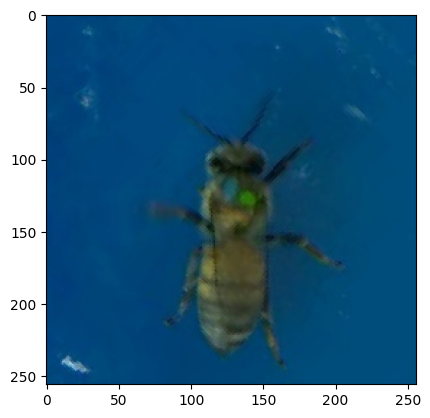

In [15]:
## Testing the model in a single image

# Loading and preparing the image

#Define the transformation
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Load the image
bee_image = Image.open('/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-blue-white-outside_2-1-32_batch_1.mp4.mp4.track000131.frame026487.jpg')

# Display the image
plt.imshow(bee_image)
plt.show()

# Apply the transformation
bee_image = transform(bee_image)

# Add an extra dimension for batch size
bee_image = bee_image.unsqueeze(0)

# Move the image to the GPU
bee_image = bee_image.cuda()

#samples = [bee_image]

# Run the image through the model
results = model_reid(bee_image)

In [16]:
results[0].shape
torch.sum(results**2)
results[0]

tensor([124.0733, -25.6968, -22.4732, -23.3684, -25.2746, -22.4023, -24.1316,
        -20.7594, -27.5245, 136.6432, -28.3069, -32.0020, -22.0771, -21.7418,
        -28.1617, -31.4371], device='cuda:0', grad_fn=<SelectBackward0>)

In [9]:
# Loading multiple images from a CSV 
# Define the transformation
# transform = transforms.Compose([
#     #transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
#     transforms.ToTensor(),  # Convert the image to a tensor
#     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
# ])

# # Read the CSV file
# df = pd.read_csv('path_to_your_csv.csv')

# # Initialize a list to hold the tensors
# images = []

# # Loop over the image paths in the CSV file
# for image_path in df['image_path']:
#     # Load the image
#     image = Image.open(image_path)
#     # Apply the transformation
#     image = transform(image)
#     # Add an extra dimension for batch size
#     image = image.unsqueeze(0)
#     # Add the image tensor to the list
#     images.append(image)

# # Concatenate all image tensors into a single tensor
# images = torch.cat(images, 0)

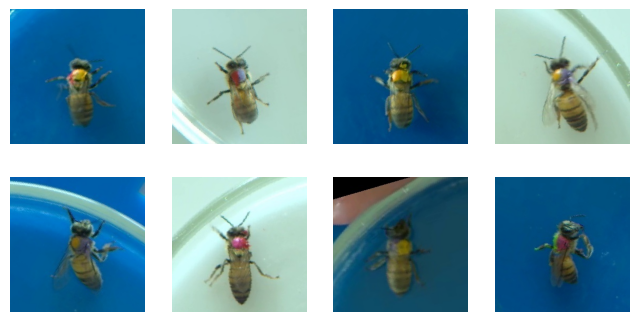

In [14]:
# Get N random samples

N = 8  # Number of random samples

#df = pd.read_csv('/home/gsantiago/summer_bee_data/open_sets/open_reference_query_testing_batch1/summer_bee_dataset_closed_test_bee_query_64_ids_batch1.csv')
df = pd.read_csv('/home/gsantiago/summer_bee_data/open_sets/open_reference_query_testing_batch2/summer_bee_dataset_closed_test_bee_query_64_ids_batch2.csv')
samples = df['filepath'].sample(N).values.tolist()
#samples = samples.cpu().detach().numpy()
# samples = df.sample(N_samples).filename.values
# samples = next(iter(samples.batch(10))).numpy()


# samples = df['filepath'].sample(N).values.tolist()

#samples = ['/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-blue-white-outside_2-1-32_batch_1.mp4.mp4.track000131.frame026487.jpg',]
            # '/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-blue-white-outside_2-1-32_batch_1.mp4.mp4.track000121.frame025417.jpg',
            # '/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-blue-white-outside_2-1-32_batch_1.mp4.mp4.track000150.frame031011.jpg']

n = len(samples)
rows = n // 4
fig, axs = plt.subplots(rows, 4, figsize=(8, 2*rows))

for i, filepath in enumerate(samples):
    img = Image.open(filepath)
    axs[i//4, i%4].imshow(img)
    axs[i//4, i%4].axis('off')  # to hide the axis

plt.savefig('output.png', dpi=300)
plt.show()

samples = filename2image(samples, [])
samples = samples.to('cuda')

#print(samples[0].shape)



Grabbing samples for reid 68, color_id is yellow-pink
Grabbing samples for reid 99, color_id is white-green
Grabbing samples for reid 117, color_id is lillac-white
Grabbing samples for reid 93, color_id is pink-white


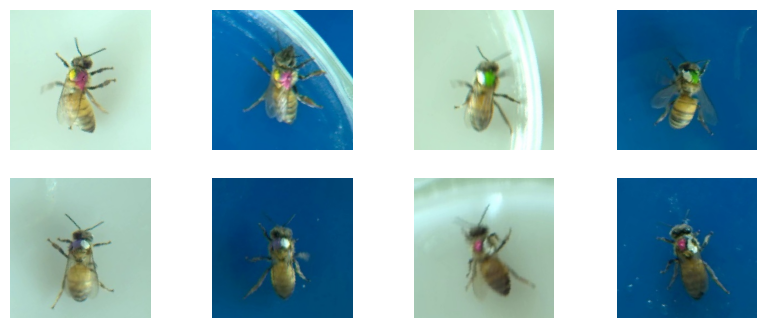

In [6]:
#Get N images from specific IDs

N = 1  # Number of random samples
#df = pd.read_csv('/home/gsantiago/summer_bee_data/open_sets/open_reference_query_testing_batch1/summer_bee_dataset_closed_test_bee_query_64_ids_batch1.csv')
df = pd.read_csv('/home/gsantiago/summer_bee_data/open_sets/open_reference_query_testing_batch2/summer_bee_dataset_closed_test_bee_query_64_ids_batch2.csv')

# samples = df['filepath'].sample(N).values.tolist()

# Grabbing N random white background and a random blue background image of the specified reids to evaluate
samples = []

reids_to_eval = np.array([68, 99, 117, 93], dtype=np.int64)

for reid in reids_to_eval:
    print(f'Grabbing samples for reid {reid}, color_id is {df[df["reID"] == reid]["color_id"].values[0]}')
    reid_df = df[(df['reID'] == reid) & (df['environment'] == 'outside')] 
    #reid_df = reid_df[reid_df['environment'] == 'in-lab'] # Filter by environment
    background_reid_df = reid_df[reid_df['background'] == 'white']
    samples.extend(background_reid_df['filepath'].sample(N).values) # Grab N random samples
    background_reid_df = reid_df[reid_df['background'] == 'blue']
    samples.extend(background_reid_df['filepath'].sample(N).values) # Grab N random samples

#Manually adding some blurry images to compare
# samples[0] = '/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-white-blue-outside-65-96_batch_2_pass_1.mp4.mp4.track000220.frame015993.jpg'
# samples[1] = '/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.mp4.track000239.frame026733.jpg'
# samples[2] = '/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-white-blue-outside-65-96_batch_2_pass_1.mp4.mp4.track000053.frame005271.jpg'
# samples[3] = '/home/gsantiago/summer_bee_data/summer_bee_data/images/young-adults-white-blue-outside-65-96_batch_2_pass_1.mp4.mp4.track000064.frame006046.jpg'

n = len(samples)
rows = n // 4
fig, axs = plt.subplots(rows, 4, figsize=(10, 2*rows))

for i, filepath in enumerate(samples):
    img = Image.open(filepath)
    axs[i//4, i%4].imshow(img)
    axs[i//4, i%4].axis('off')  # to hide the axis

plt.show()

samples = filename2image(samples, [])
samples = samples.to('cuda')

#print(samples[0].shape)

Grabbing sample for reid 68, color_id is yellow-pink
Grabbing sample for reid 99, color_id is white-green
Grabbing sample for reid 117, color_id is lillac-white
Grabbing sample for reid 93, color_id is pink-white


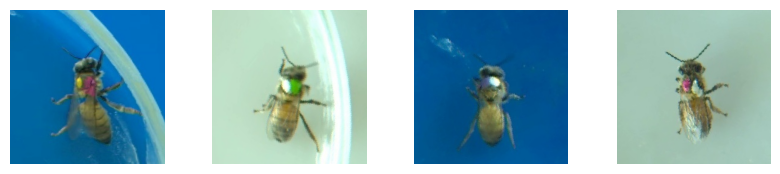

In [7]:
# Get 4 images from random or specific reids

df = pd.read_csv('/home/gsantiago/summer_bee_data/open_sets/open_reference_query_testing_batch2/summer_bee_dataset_closed_test_bee_query_64_ids_batch2.csv')

samples = []

# Get 4 random IDs from 65 to 127
#reids_to_eval = np.random.randint(65, 127, size=4)

# Get 4 specific reids
reids_to_eval = [68, 99, 117, 93]


backgrounds = ['blue', 'white']  # List of backgrounds to cycle through

for i, reid in enumerate(reids_to_eval):
    print(f'Grabbing sample for reid {reid}, color_id is {df[df["reID"] == reid]["color_id"].values[0]}')
    reid_df = df[(df['reID'] == reid) & (df['environment'] == 'outside')] 

    background = backgrounds[i % len(backgrounds)]  # Alternate between backgrounds
    background_reid_df = reid_df[reid_df['background'] == background]
    if not background_reid_df.empty:  # Check if the DataFrame is not empty
        samples.append(background_reid_df['filepath'].iloc[0])  # Grab the first sample


n = len(samples)
rows = (n + 3) // 4  # Add an extra row if n is not a multiple of 4
fig, axs = plt.subplots(rows, 4, figsize=(10, 2*rows))

for i, filepath in enumerate(samples):
    img = Image.open(filepath)
    if rows == 1:
        axs[i%4].imshow(img)
        axs[i%4].axis('off')  # to hide the axis
    else:
        axs[i//4, i%4].imshow(img)
        axs[i//4, i%4].axis('off')  # to hide the axis

plt.show()

samples = filename2image(samples, [])
samples = samples.to('cuda')

In [20]:
occlusion_size = 32
stride = 4

In [21]:
torch.cuda.empty_cache()

In [22]:
# Careful, use batch size 1 if there are batch norms in the model
# otherwise, the results will change depending on the batch size
# it shouldn't be this way, check Rafael's custom model code for some possible batchnorm mistakes 
# (maybe they don't turn off in eva l mode)
results_reid = get_occlusion_maps(model_reid, samples, occlusion_size=occlusion_size, stride=stride, model_type='reid', occlusion_value=0, batch_size=1, verbose=False, plot_occluded_imgs=False)
print(results_reid[0].shape)
results_color = get_occlusion_maps(model_color, samples, occlusion_size=occlusion_size, stride=stride, model_type='color_detect', occlusion_value=0, batch_size=1, verbose=False, plot_occluded_imgs=False)
print(results_color[0].shape)
torch.cuda.empty_cache()


Length of occluded_images: 3249
Length of occluded_images: 3249
Length of occluded_images: 3249
Length of occluded_images: 3249
Total time: 4.363741425673167
(256, 256)
Length of occluded_images: 3249
Length of occluded_images: 3249
Length of occluded_images: 3249
Length of occluded_images: 3249
Total time: 4.418220702807108
(256, 256)


In [186]:
# Careful, use batch size 1 if there are batch norms in the model
# otherwise, the results will change depending on the batch size
# it shouldn't be this way, check Rafael's custom model code for some possible batchnorm mistakes 
# (maybe they don't turn off in eval mode)
# results_thick = get_occlusion_maps_reID(model, samples, occlusion_size=32, stride=4, occlusion_value=0, batch_size=1, verbose=True, plot_occluded_imgs=False)
# torch.cuda.empty_cache()


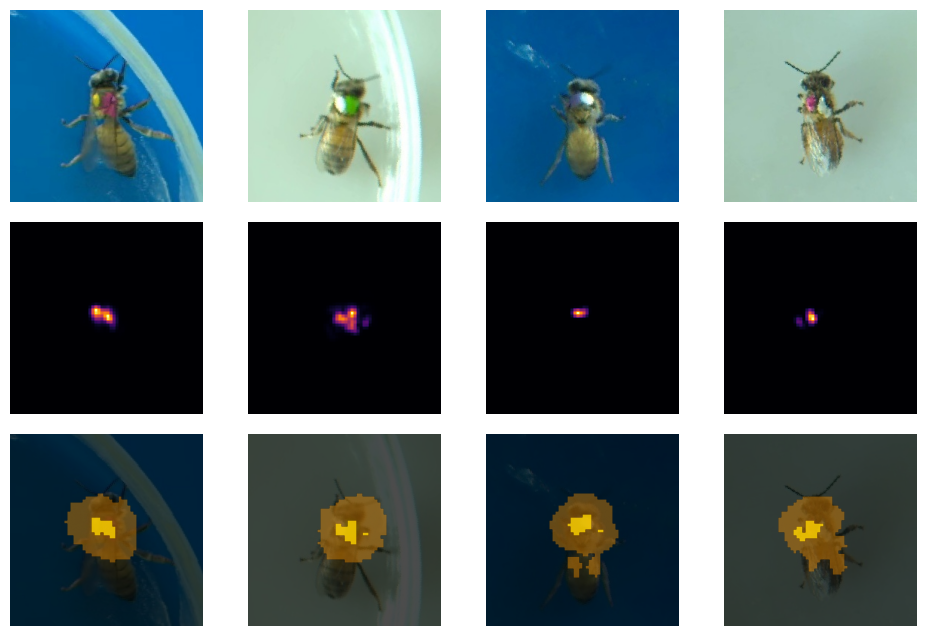

In [59]:
plot_occlusion_maps(samples, results_reid, savefig=False, figname='occlusion-size-8-stride-4-percentile-1-and-10.png', quantile1=0.99, quantile2=0.9)

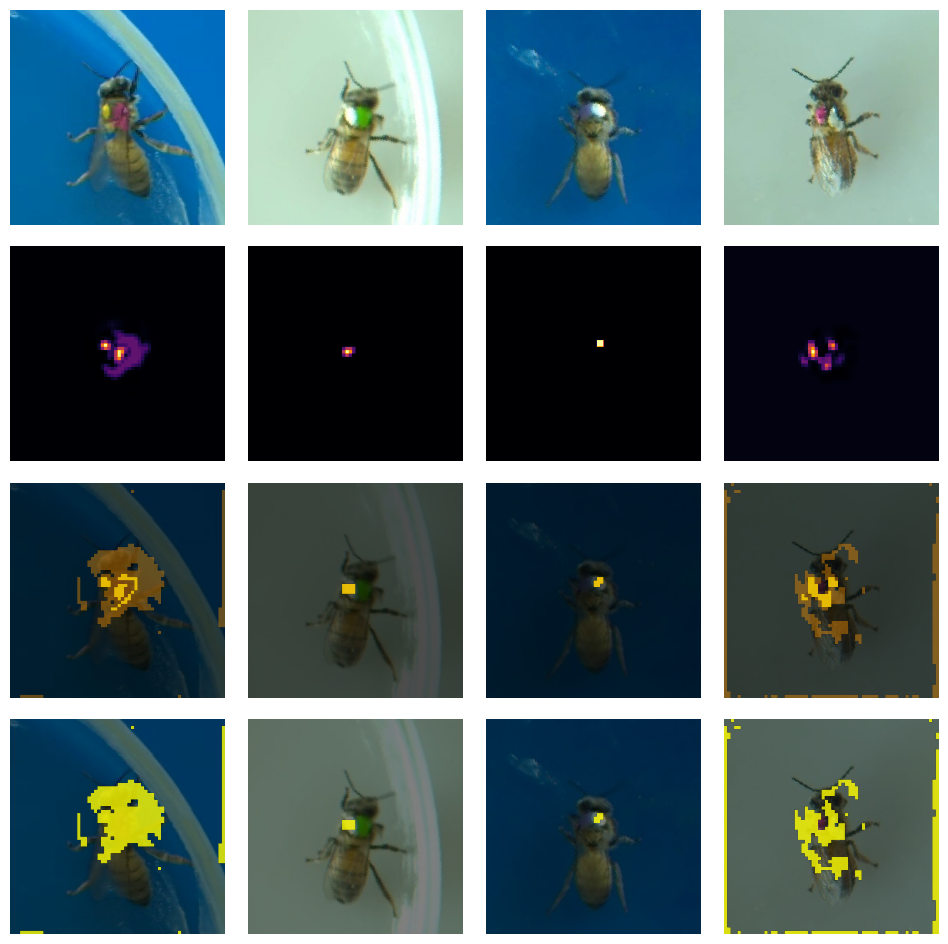

In [55]:
plot_occlusion_maps(samples, results_color, savefig=False, figname='occlusion-size-8-stride-4-percentile-1-and-10.png', quantile1=0.99, quantile2=0.9)

In [29]:
# plot_occlusion_maps(samples, results_thick, savefig=False, figname=None)

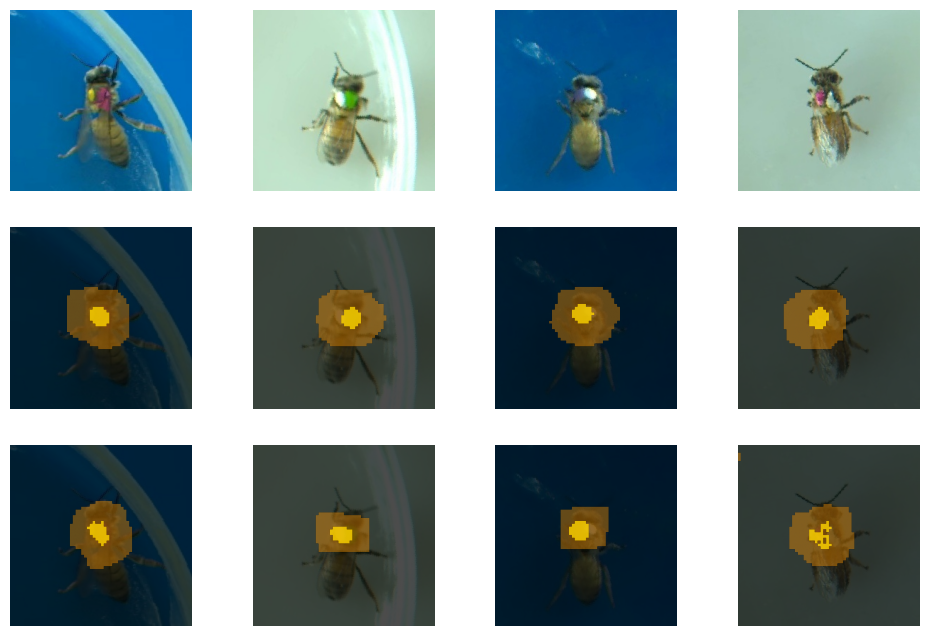

In [28]:
### FIGURE FOR PAPER

N = len(samples)
quantile1 = 0.99
quantile2 = 0.9



fig = plt.figure(figsize=(3*N, 2*N))  # Adjust the figure size to accommodate 3 rows
for k in range(N):
    # Plot the original image
    ax = plt.subplot(3, N, k+1)
    ax.axis('off')
    # Transpose the image data to the correct shape
    image = samples[k].permute(1, 2, 0).cpu()
    plt.imshow(image)  

    # Plot the occlusion map with thresholding overlayed in the original image
    result = results_reid[k]
    thresholded_results = (results_reid[k] > np.quantile(results_reid[k], quantile1)).astype(int)
    ax3 = plt.subplot(3, N, N+k+1)
    ax3.axis('off')
    plt.imshow(samples[k].permute(1, 2, 0).cpu()*0.3) # Multiplying by 0.5 to make the image darker
    show_mask(thresholded_results, ax3)
    thresholded_results = (results_reid[k] > np.quantile(results_reid[k], quantile2)).astype(int)
    show_mask(thresholded_results, ax3, mask_num=2)

    # Plot the occlusion map with thresholding overlayed in the original image
    result = results_color[k]
    thresholded_results = (results_color[k] > np.+quantile(results_color[k], quantile1)).astype(int)
    ax3 = plt.subplot(3, N, 2*N+k+1)
    ax3.axis('off')
    plt.imshow(samples[k].permute(1, 2, 0).cpu()*0.3) # Multiplying by 0.5 to make the image darker
    show_mask(thresholded_results, ax3)
    thresholded_results = (results_color[k] > np.quantile(results_color[k], quantile2)).astype(int)
    show_mask(thresholded_results, ax3, mask_num=2)

# plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Set the same space for width and height


plt.savefig('occlusion.png', dpi=300)


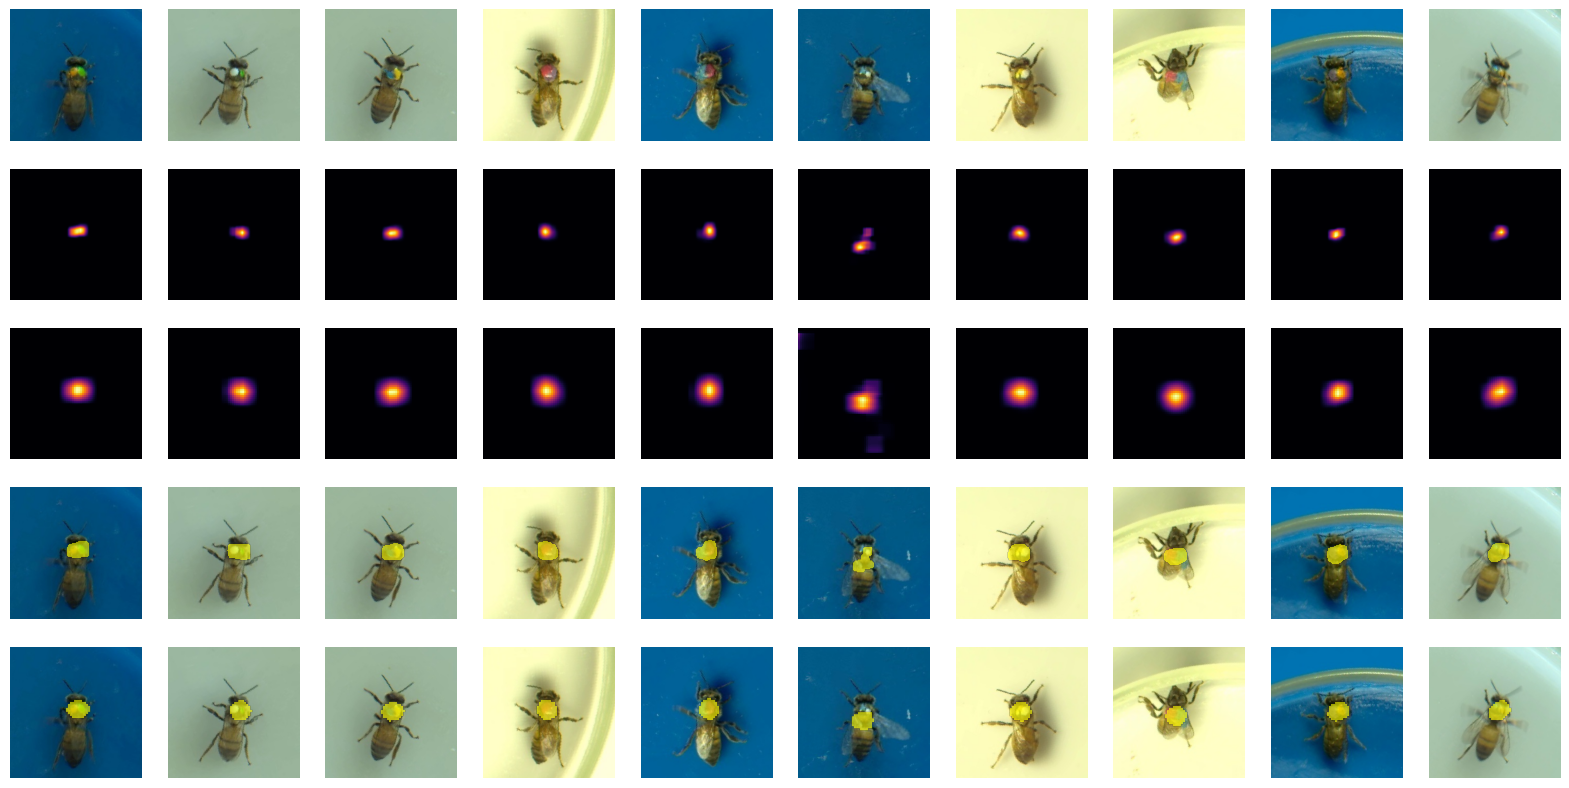

In [101]:
plot_occlusion_maps_two_sizes(samples, results_small, results_thick, quantile=0.98, savefig=True, figname='10-random-samples.png')

<class 'numpy.ndarray'>


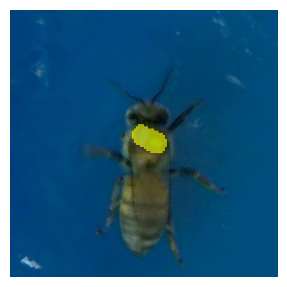

In [57]:
results2 = np.array(results_small).copy()
print(type(results2))
for k in range(results2.shape[0]):
    results2[k] = (results2[k] > np.quantile(results2[k], 0.99)).astype(int)

plt.figure(figsize=(20,10))
for k in range(samples.shape[0]):  
    ax = plt.subplot(2,5,k+1)
    ax.axis('off')
    plt.imshow(samples[k].permute(1, 2, 0).cpu())
    show_mask(results2[k], ax)
plt.show()